In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as f


import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter


In [2]:
training_data = datasets.MNIST(root = "data",train = True,download = True,transform = ToTensor())
testing_data = datasets.MNIST(root = "data",train = False,download = True,transform = ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 132298441.23it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107485087.69it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 104816407.70it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18143360.73it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
batch_size=60
train_dataloader=DataLoader(training_data,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(testing_data,batch_size=batch_size,shuffle=True)

In [4]:
len(training_data)

60000

In [5]:
class NeuralNetwork(nn.Module):

  def __init__(self):
    super(NeuralNetwork,self).__init__()

    ## Init function is used to define the architecture blocks
    self.flatten = nn.Flatten() # 28 x 28 x1 - 784 x 1 vector
    self.layer1 = nn.Linear(784,512)
    self.dropout1=nn.Dropout(0.4)
    self.layer2 = nn.Linear(512,256)
    self.dropout2=nn.Dropout(0.3)
    self.layer3 = nn.Linear(256,10)

  def forward(self,x):
    x = self.flatten(x)
    x = self.layer1(x)
    x = self.dropout1(x)
    x = f.relu(x) #F.sigmoid()
    x = self.layer2(x)
    x = self.dropout2(x)
    x = f.sigmoid(x)
    x = self.layer3(x)
    return x

device = ("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork()
model.to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)


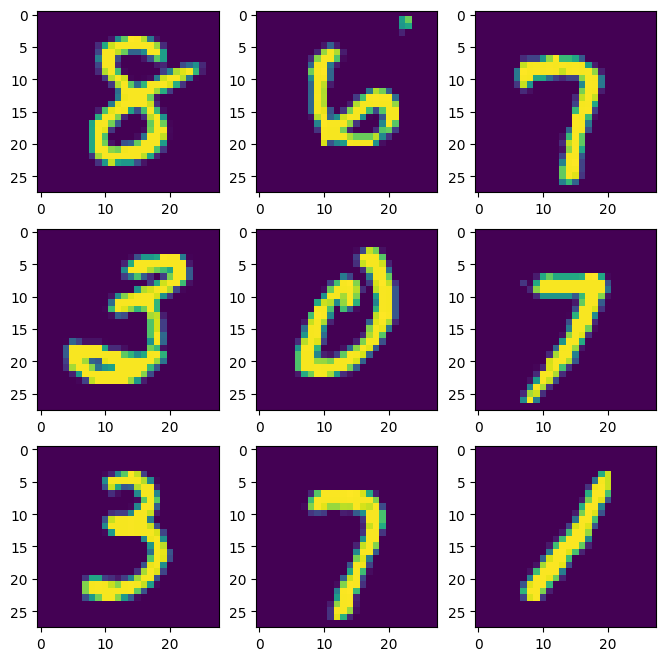

In [6]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3,3

for i in range(1,rows*cols+1):
  sample_idx = torch.randint(len(training_data),size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  #plt.title(labels_map[label])
  plt.imshow(img.squeeze())

In [7]:
# Initialize TensorBoard writer

writer = SummaryWriter('runs/fashion_mnist') #runs is a directory under this fashion_minst file is created

In [13]:
#Adding images to tensor board
#we use the torchvision.utils.make_grid() to convert a batch of tensor into 3xHxW format

#writer.add_image('img', img)
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
#plt.imshow(img_grid)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [34]:
train_loss=0.0
def train_loop(train_dataloader,model,loss_fn,optimizer):
  train_loss=0.0
  for batch, (X,y) in enumerate(train_dataloader):
    X = X.to(device)
    y = y.to(device)


    pred = model(X)
    loss = loss_fn(pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss=+loss.item()

    # Calculate average training loss for this epoch
  train_loss =  train_loss / len(train_dataloader)
    #print(runing_loss)

  return train_loss

In [39]:
test_loss=0.0
def test_loop(test_dataloader,model,loss_fn):
  test_loss=0.0
  model.eval()

  for X,y in test_dataloader:
     X = X.to(device)
     y = y.to(device)

     pred = model(X)
  test_loss += loss_fn(pred,y).item()
  test_loss = test_loss/len(test_dataloader)

  print(f'Test Loss: {test_loss:.4f}')

In [40]:
epoch=5
for t in range(epoch):
  train_loop(train_dataloader,model,loss_fn,optimizer)
  test_loop(test_dataloader,model,loss_fn)


Test Loss: 0.0014
Test Loss: 0.0008
Test Loss: 0.0020
Test Loss: 0.0021
Test Loss: 0.0008


In [41]:
# Log training loss to TensorBoard
writer.add_scalar('Training Loss',train_loss, epoch + 1)
writer.add_scalar('Testing Loss',test_loss, epoch + 1)

#print(f'Epoch [{epoch + 1}/10], Train Loss: {runing_loss}')

for name, param in model.named_parameters():
 writer.add_histogram(name, param, epoch + 1)  #for adding histograms

In [42]:
print(train_loss)

0.0


In [43]:
# Close TensorBoard writer
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs
%reload_ext tensorboard